So for this one, we're going to try to backsolve the weights for FanGraphs' wOBA calculation.  They're actually already up, but I still thought it'd be fun to see how accurately I can compute them on my own.  

My longterm goal here is to backsolve as much of their WAR components as I can to see how accurately I can recreate it; that starts with their offensive component, which is largely backed by wOBA.  wOBA is basically a statistic that is supposed to take every offensive outcome into account together with their associated run values.  That is, a single isn't worth a quarter of a home run; they actually on average result in a bit under a run while home runs tend to result in a bit over 2 runs on average.  The goal is to take all of that into account and derive a number that tells you how good a hitter is overall in a way that looks similar to OBP, which you might have more familiarity with.

We know from their description of the statistic what numbers go into it; luckily for us, they're all just counting statistics.  You can see the actual formula here (with what appear to be weights from 2013):

wOBA = (0.690×uBB + 0.722×HBP + 0.888×1B + 1.271×2B + 1.616×3B +
2.101×HR) / (AB + BB – IBB + SF + HBP)

In any case, we first need to import the necessary libraries and the data set (which consists of all players with at least 200 PA).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as  plt

from sklearn import linear_model
from sklearn import svm, preprocessing, cross_validation
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

C:\Users\jfahe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('FanGraphswOBA.csv')
df.head()

,Name,Team,AB,BB,IBB,HBP,SF,1B,2B,3B,HR,wOBA,playerid
0,Mike Trout,Angels,402,94,15,7,4,62,25,3,33,0.437,10155
1,J.D. Martinez,- - -,432,53,8,0,4,57,26,3,45,0.430,6184
2,Aaron Judge,Yankees,542,127,11,5,4,75,24,3,52,0.430,15640
3,Joey Votto,Reds,559,134,20,8,6,108,34,1,36,0.428,4314
4,Rhys Hoskins,Phillies,170,37,1,3,2,19,7,0,18,0.417,16472


First things first, we need to create the variable for unintentional walks, which is just BB - IBB.  The denominator in the equation also looks like it's just PA without intentional walks, so we can recreate that too.

In [3]:
df['uBB'] = df['BB'] - df['IBB']
df['PA'] = df['AB'] + df['uBB'] + df['SF'] + df['HBP']

In [4]:
df.head()

,Name,Team,AB,BB,IBB,HBP,SF,1B,2B,3B,HR,wOBA,playerid,uBB,PA
0,Mike Trout,Angels,402,94,15,7,4,62,25,3,33,0.437,10155,79,492
1,J.D. Martinez,- - -,432,53,8,0,4,57,26,3,45,0.430,6184,45,481
2,Aaron Judge,Yankees,542,127,11,5,4,75,24,3,52,0.430,15640,116,667
3,Joey Votto,Reds,559,134,20,8,6,108,34,1,36,0.428,4314,114,687
4,Rhys Hoskins,Phillies,170,37,1,3,2,19,7,0,18,0.417,16472,36,211


Just for fun, I generated a distribution plot of the wOBA values in our data set.  As you can see, most players tend to fall somewhere in the .250-.400 range.  Looks about right to me.

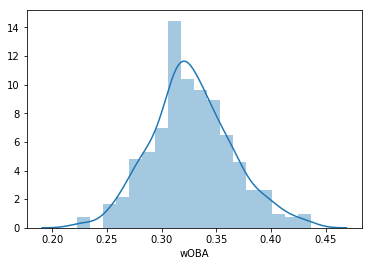

In [5]:
sb.distplot(df['wOBA'])
plt.show()

Now we're ready to start prepping our data set for modeling.  We can drop the variables we know don't matter (name, team, and ID) as well as variables that are already accounted for and don't need their own weights (overall walks and intentional walks).

In [6]:
df_clean = df.drop(['Name','Team','AB','IBB','BB','playerid'],axis = 1)

In [7]:
cols = df_clean.columns.tolist()
cols.remove('wOBA')
cols.append('wOBA')
cols

['HBP', 'SF', '1B', '2B', '3B', 'HR', 'uBB', 'PA', 'wOBA']

In [8]:
df_clean = df_clean[cols]

In [9]:
df_clean.describe()

,HBP,SF,1B,2B,3B,HR,uBB,PA,wOBA
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,4.372493,2.965616,67.985673,21.624642,1.977077,16.071633,37.836676,452.988539,0.327536
std,3.876534,2.149303,27.198447,9.334436,2.062122,10.284908,19.690543,144.768701,0.037286
min,0.000000,0.000000,19.000000,2.000000,0.000000,0.000000,8.000000,200.000000,0.223000
25%,2.000000,1.000000,47.000000,15.000000,0.000000,8.000000,23.000000,328.000000,0.305000
50%,4.000000,3.000000,66.000000,20.000000,1.000000,14.000000,34.000000,457.000000,0.325000
75%,6.000000,4.000000,87.000000,28.000000,3.000000,23.000000,49.000000,575.000000,0.349000
max,24.000000,12.000000,170.000000,56.000000,14.000000,59.000000,116.000000,713.000000,0.437000


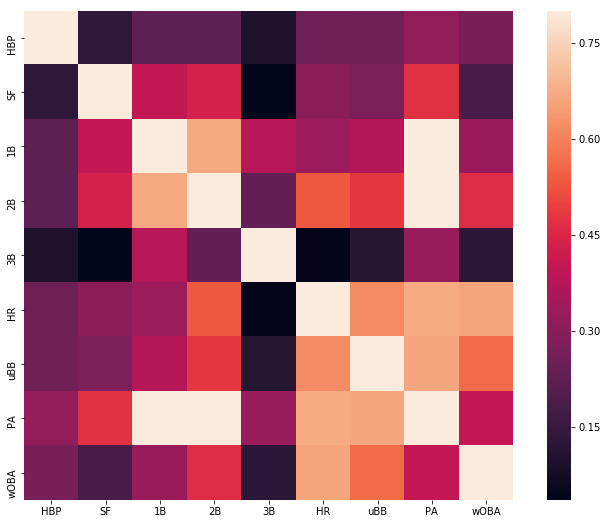

In [10]:
corrmat = df_clean.corr()
f, ax = plt.subplots(figsize=(12, 9))
sb.heatmap(corrmat, vmax=.8, square=True)
plt.show()

This is a correlation heatmap that shows how much each variable correlates which each other.  We can see that not very many of these seem to correlate very strongly at all with wOBA, which is a little troubling.  But let's just keep going and see what happens.

In [11]:
X = np.array(df_clean.drop(['wOBA'],1))
X = preprocessing.scale(X)
y = np.array(df_clean.wOBA)

C:\Users\jfahe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size = 0.3)

In [13]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_test,y_test))

0.864298833095


In [14]:
coef_list = list(lm.coef_)
col_list = list(df_clean.columns)
col_list = col_list[0:(len(col_list)-1)]
weight_df = pd.DataFrame(columns=['Variable','Weight'])
weight_df['Variable'] = col_list
weight_df['Weight'] = coef_list

In [15]:
weight_df

,Variable,Weight
0,HBP,0.006022
1,SF,-0.000252
2,1B,0.045315
3,2B,0.023268
4,3B,0.005983
5,HR,0.038637
6,uBB,0.025498
7,PA,-0.088337


So this wasn't bad, but the linear regressor is the only thing that even remotely works here.  One thing you could try is transforming all of the input variables into their per-PA rates, which means you'd no longer have PA as a predictor.  

In [16]:
df_clean.columns

Index(['HBP', 'SF', '1B', '2B', '3B', 'HR', 'uBB', 'PA', 'wOBA'], dtype='object')

In [17]:
for i in cols[0:7]:
    df_clean[str(i)] = df_clean[str(i)]/df_clean['PA']

In [18]:
df_clean = df_clean.drop('PA',axis=1)

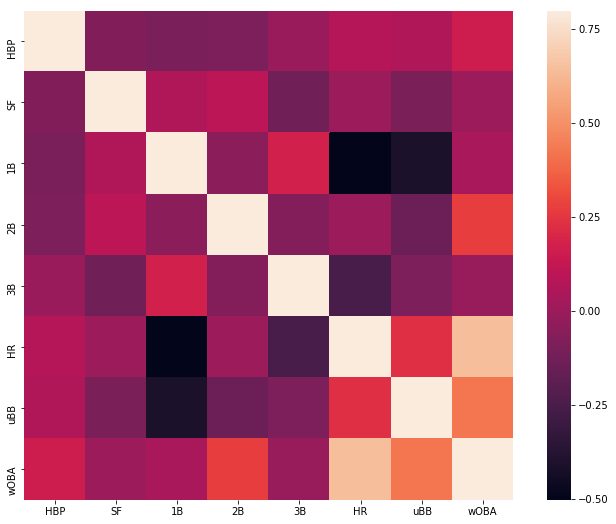

In [19]:
corrmat = df_clean.corr()
f, ax = plt.subplots(figsize=(12, 9))
sb.heatmap(corrmat, vmax=.8, square=True)
plt.show()

Still not quite as much strong correlation as we'd like to see, but some of the features do seem a lot stronger.  Let's try modeling it again and see what happens.

In [20]:
X = np.array(df_clean.drop(['wOBA'],1))
X = preprocessing.scale(X)
y = np.array(df_clean.wOBA)

In [21]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size = 0.3)

In [22]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_test,y_test))

0.999934945539


In [23]:
coef_list = list(lm.coef_)
col_list = list(df_clean.columns)
col_list = col_list[0:(len(col_list)-1)]
weight_df = pd.DataFrame(columns=['Variable','Weight'])
weight_df['Variable'] = col_list
weight_df['Weight'] = coef_list

In [24]:
weight_df

,Variable,Weight
0,HBP,0.006006
1,SF,0.000018
2,1B,0.027429
3,2B,0.015201
4,3B,0.006496
5,HR,0.033950
6,uBB,0.021553


So that went literally perfectly.  Luckily for us, park adjustments aren't applied until after wOBA is converted to RC, so for now, we have a perfect recreation of offensive output. 

The next step is to convert wOBA to wRAA (weighted Runs Above Average).  Their formula is given with this equation:

((wOBA-League wOBA)/wOBA Scale)*PA = wRAA

This step is really pretty simple; we just need to subtract the league average wOBA from each player's wOBA, divide by their wOBA scale (which is just there to convert wOBA into a number that more closely resembles OBP), and multiply by PA.  We're kind of going to cheat here and just use their league average wOBA (.321) without computing it ourselves because the dataset we went with leaves out all of the players that didn't reach 200 PA (meaning the true league average is a bit lower than what we'd get).  We're also just going to use their given scale value (1.185).

First, we need to derive and store all of the predicted wOBA values and then create a PA column that also includes IBB (which they exclude from PA in the wOBA calculation).

In [25]:
df['pred_wOBA'] = lm.predict(X)

In [26]:
df['pred_wRAA'] = (df['pred_wOBA'] - .321)/1.185 * (df['PA'] + df['IBB'])

In [27]:
df.head()

,Name,Team,AB,BB,IBB,HBP,SF,1B,2B,3B,HR,wOBA,playerid,uBB,PA,pred_wOBA,pred_wRAA
0,Mike Trout,Angels,402,94,15,7,4,62,25,3,33,0.437,10155,79,492,0.437002,49.631253
1,J.D. Martinez,- - -,432,53,8,0,4,57,26,3,45,0.430,6184,45,481,0.430285,45.097467
2,Aaron Judge,Yankees,542,127,11,5,4,75,24,3,52,0.430,15640,116,667,0.430317,62.546135
3,Joey Votto,Reds,559,134,20,8,6,108,34,1,36,0.428,4314,114,687,0.428324,64.032053
4,Rhys Hoskins,Phillies,170,37,1,3,2,19,7,0,18,0.417,16472,36,211,0.417406,17.247271


So now we have our predicted wRAA.  The last step before we arrive at our final calculation for batting runs is to take two things into account: what park they play in and what league they're in (AL or NL).  They give the formula for that here:

Batting Runs = wRAA + (lgR/PA – (PF*lgR/PA))*PA + (lgR/PA – (AL or NL non-pitcher wRC/PA))*PA

This poses a bit of a tougher problem.  I could find a way to derive the run values for what league a player is in, but I have no means of just grabbing their park factors given that FanGraphs only has them up for 2015.  I suppose given that I can compute the league part, I could just backsolve those too using our wRAA predictions and comparing them against the position player batting runs.  I might save that for another time.